In [1]:
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from pybatteryid.simulation import simulate_model
from pybatteryid.utilities import load_model_from_file
from pybatteryid.plotter import plot_time_vs_current, plot_time_vs_voltage

from data import helper

### Example 4 - Model Validation for an LFP Battery

This file contains an example to validate the identified battery models for a 3.5 Ah LFP battery. A test current profile as used in [2] is applied as an input to the model to simulate the voltage output.

#### References

[1] Sheikh, A. M. A., M. C. F. Donkers, and Henk Jan Bergveld. "A comprehensive approach to sparse identification of linear parameter-varying models for lithium-ion batteries using improved experimental design." Journal of Energy Storage 95 (2024): 112581. https://doi.org/10.1016/j.est.2024.112581

[2] A. M. A. Sheikh, H. J. Bergveld and M. C. F. Donkers, "Investigating Identification Input Designs for Modelling Lithium-ion Batteries with Hysteresis Using LPV Framework," 2024 American Control Conference (ACC), Toronto, ON, Canada, 2024, pp. 1952-1958. https://doi.org/10.23919/ACC60939.2024.10644893.

#### A. Load model

We load the identified battery model from a file.

In [2]:
model = load_model_from_file( 'results/lfp/model_one_n,l=1,1.npy' )

#### B. Simulate output voltage

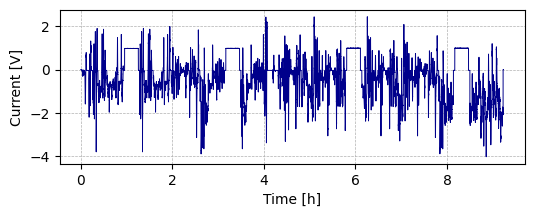

In [3]:
#
dataset = helper.load_npy_datasets(f'data/lfp/validation_data.npy')
#
plot_time_vs_current([(dataset['time'] / 3600, dataset['current'])],
                     units=('h', 'V'), colors=['darkblue'])

In [4]:
# To perform fair comparison, we provide same number of initial
# voltage values to each model. For example, the model with n=4
# requires four initial voltage values. If n=4 is the largest model
# order to be investigated, then we provide four initial values to all
# models, that is, n=1,2,3,4. Note that such consideration may not have
# significant impact on the actual comparison, but is legit in principle.
no_of_initial_values = 4
# 
current_profile = {'initial_soc': dataset['initial_soc'],
                   'time_values': dataset['time'],
                   'current_values': dataset['current'],
                   'voltage_values': dataset['voltage'][:no_of_initial_values]}
#
voltage_simulated = simulate_model(model, current_profile)

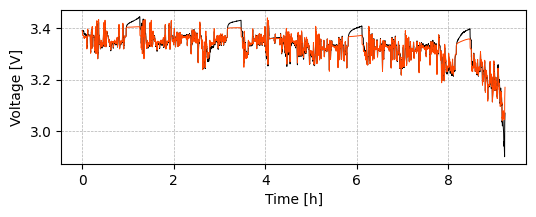

In [5]:
#
plot_time_vs_voltage([(dataset['time'] / 3600, dataset['voltage']), (dataset['time'] / 3600, voltage_simulated)],
                     units=('h', 'V'), colors=['k', 'orangered'])

#### C. Error Analysis

In [6]:
# We define a function that takes a list of indices defining slices
# and calculates error values for the combined region.
def find_rmse_mae_for_subregions(region_slices):
    #
    simulated_voltage_regions = np.concatenate([ voltage_simulated[ idx[0]:idx[1] ] for idx in region_slices ])
    measured_voltage_regions = np.concatenate([  dataset['voltage'][ idx[0]:idx[1] ] for idx in region_slices ])
    #
    rmse = root_mean_squared_error( simulated_voltage_regions, measured_voltage_regions )
    mae = mean_absolute_error( simulated_voltage_regions, measured_voltage_regions )

    return rmse, mae

In [7]:
# We define slices for region A and region B
region_A_slices = [(no_of_initial_values, 3350), (4600, 11330), (12570, 20820), (22100, 29320), (30600, len(voltage_simulated))]
region_As_total = [(dataset['time'][ idx[0]:idx[1] ] / 3600, voltage_simulated[ idx[0]:idx[1] ]) for idx in region_A_slices]
#
region_B_slices = [(3350, 4600), (11330, 12570), (20820, 22100), (29320, 30600)]
region_Bs_total = [(dataset['time'][ idx[0]:idx[1] ] / 3600, voltage_simulated[ idx[0]:idx[1] ]) for idx in region_B_slices]

# We find error values for the whole region
rmse = root_mean_squared_error( voltage_simulated[no_of_initial_values:], dataset['voltage'][no_of_initial_values:] )
mae = mean_absolute_error( voltage_simulated[no_of_initial_values:], dataset['voltage'][no_of_initial_values:] )

# We find error values separately for regions A and B
rmse_A, mae_A = find_rmse_mae_for_subregions(region_A_slices)
rmse_B, mae_B = find_rmse_mae_for_subregions(region_B_slices)

print(f"The errors are given as: (RMSE, MAE) = ({rmse * 1e3} mV, {mae * 1e3} mV)")
print(f"Region A -- red: (RMSE, MAE) = ({rmse_A * 1e3} mV, {mae_A * 1e3} mV)")
print(f"Region B -- green: (RMSE, MAE) = ({rmse_B * 1e3} mV, {mae_B * 1e3} mV)")

The errors are given as: (RMSE, MAE) = (13.378653490083884 mV, 8.063439222719715 mV)
Region A -- red: (RMSE, MAE) = (9.671250444517527 mV, 5.303614100050356 mV)
Region B -- green: (RMSE, MAE) = (25.614771625842703 mV, 23.472553907627677 mV)
